+ Requirements:
    1. The estimated time to carry out this activity is approximately 1 hour.
<br><br>
+ Objectives of the notebook:
    1. Introduction to Pytorch
    2. Understand the multilayer perceptron
<br><br>
+ Summary of activities:
    1. To achieve these objectives, we will analyze pieces of code in Pytorch.
<br><br>

%%latex
\tableofcontents
\newpage

# Introduction
The multilayer perceptron is an artificial neural network (NN) made up of multiple layers, where each layer is made up of several neurons.

# Sample code in Pytorch
Below is a Pytorch code example of a perceptron and its training to approximate the logical function XOR of two binary inputs.

- In Python you always start by importing all the required modules:

In [1]:
import numpy as np
import torch
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

1.7.0


## Create a dataset (dataloader class)

- Taking advantage of the functionality of Pytorch, the dataset is created with the input data and the outputs of the function (or labels).

In [3]:
# This problem is posed as a classification
n_classes = 2

# We create the dataset and an iterable.
class my_points(data.Dataset):
    def __init__(self, n_samples):
        self.n_tuples = int(n_samples/4)
        self.n_samples = self.n_tuples * 4
        pd_data = np.tile(np.array([[0.,0.,0.],[1.,1.,0.],[1.,0.,1.],[0.,1.,1.]]), (self.n_tuples, 1) ) # data
        self.data = pd_data[:, 0:2]  # 1st and 2nd columns --> x,y
        self.target = pd_data[:, 2:]  # 3nd column --> label

    def __len__(self):  # Length of the dataset.
        return self.n_samples

    def __getitem__(self, index):  # Function that returns one point and one label.
        return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])

# We create the dataloader.
# 1000 iterations -> n_points = 20000 / batch_size = 20
my_data = my_points(20000)
batch_size = 20
my_loader = data.DataLoader(my_data,batch_size=batch_size,num_workers=0)

## Multilayer Perceptron (nn.Module class)

- Taking advantage of the functionality of Pytorch, a Perceptron or a multilayer model is defined:

In [4]:
# Defining a Perceptron (n_hidden=0) or a multilayer model with two hidden layers (n_hidden=2)
class my_model(nn.Module):
    def __init__(self, n_in=2, n_hidden=2, n_out=2):
        super(my_model, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        if self. n_hidden == 0:
            self.fc1 = nn.Linear(self.n_in, self.n_out, bias=True)
        else:
            self.h = nn.Linear(self.n_in, self.n_hidden, bias=True)
            self.fc1 = nn.Linear(self.n_hidden, self.n_out, bias=True)
        self.out = nn.Softmax(dim=1)
    def forward(self, x):
        if self.n_hidden == 0:
            x = self.fc1(x)
        else:
            x = torch.sigmoid(self.h(x))
            x = torch.sigmoid(self.fc1(x))
        x=self.out(x)
        return x

# Now, we create the model, the loss function or criterium and the optimizer
# that we are going to use to minimize the loss.

# Model
#model = my_model(n_in=2, n_hidden=0, n_out=2)
model = my_model(n_in=2, n_hidden=2, n_out=2)
print(model)

my_model(
  (h): Linear(in_features=2, out_features=2, bias=True)
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (out): Softmax(dim=1)
)


## Training

- Taking advantage of the functionality of Pytorch, the parameters of the model are estimated:

In [5]:
# Loss function
criterium = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Supervised training.
epochs=10
max_iter = my_loader.__len__()*epochs
cost = np.zeros((max_iter, 1))
ucost = np.zeros((max_iter, 1))
i, c_ant, beta = 0, 0, 0.99
for _ in range(epochs):
    for k, (data, target) in enumerate(my_loader):
        # Definition of inputs as variables for the net.
        # requires_grad is set False because we do not need to compute the
        # derivative of the inputs.

        data = Variable(data, requires_grad=False)
        target = Variable(target.long(), requires_grad=False)

        # Set gradient to 0.
        optimizer.zero_grad()
        # Feed forward.
        pred = model(data)
        # Loss calculation.
        loss = criterium(pred, target.view(-1))
        # Gradient calculation.
        loss.backward()

        # Plot loss and its moving average
        # cost[i] = loss.detach().numpy()
        cost[i] = loss.item()
        c_act = (1 - beta) * cost[i] + beta * c_ant
        ucost[i] = c_act / (1 - beta ** (i + 1))
        c_ant = c_act
        i += 1

        # Print loss every 10 iterations.
        #if (k+1) % 10 == 0:
        #    print('Loss {:.4f} at iter {:d}'.format(loss.item(), k+1))

        # Model weight modification based on the optimizer.
        optimizer.step()

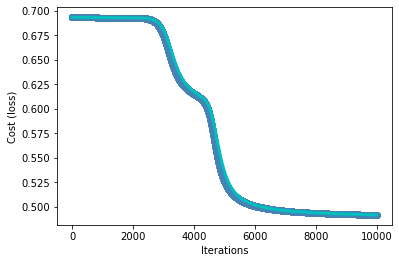

In [6]:
# Visualiza la evolución de la función de coste C durante el entrenamiento.

plt.plot(range(max_iter), cost, color='steelblue', marker='o')
plt.plot(range(max_iter), ucost,'c-', linewidth=3)
plt.xlabel("Iterations")
plt.ylabel("Cost (loss)")
plt.show(block=True)

## Evaluation and test

- The trained model is evaluated:

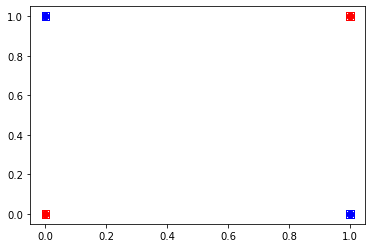

In [7]:
# Displaying the results

# Circles indicate the ground truth and the squares are the predictions.
# fig = plt.figure(1, figsize=(3 * 2, 2.5 * 2))
# plt.clf()
# plt.axes([0, 0, 1, 1])

colors = ['r','b','g','y']
points = data.numpy()

# Ground truth last batch.
target = target.numpy()
for k in range(n_classes):
    select = target[:,0]==k
    p = points[select,:]
    plt.scatter(p[:,0],p[:,1],facecolors=colors[k])

# Predictions last batch.
pred = pred.exp().detach()     # exp of the log prob = probability.
_, index = torch.max(pred,1)   # index of the class with maximum probability.
pred = pred.numpy()
index = index.numpy()
for k in range(n_classes):
    select = index==k
    p = points[select,:]
    plt.scatter(p[:,0],p[:,1],s=60,marker='s',edgecolors=colors[k],facecolors='none')

plt.show()

# References
+ [Python documentation](https://docs.python.org/es/3/)
+ [Numpy documentation](https://numpy.org/doc/)
+ [Pytorch documentation](https://pytorch.org/docs/stable/index.html)